# Yakup Gorur - S017327
# Ozyegin University
# CS 556 - BIG DATA ANALYSIS Term Project
# 2018-2019 FALL
# Version: SCIKIT-LEARN 

In [1]:
# Import Libraries
import numpy as np  # to handle matrix
import pandas as pd # to handle data
from matplotlib import pyplot as plt # to visualize
import datetime, pytz # to handle time
from sklearn.model_selection import train_test_split # Split data
from sklearn.ensemble import RandomForestRegressor # Random Forest Classifier

In [2]:
# Define a conversion function for the native timestamps in the csv file
def dateparse (time_in_secs):    
    return pytz.utc.localize(datetime.datetime.fromtimestamp(float(time_in_secs)))

# Import the datasets

After reviewing the dataset, I decided to recode the datetime since it is better to use the dataset sorted by date not by minutes because of the dataset which I use.
Then I group the dataset by date.

In [3]:
# Import the dataset and encode the date
df = pd.read_csv('coinbaseUSD.csv',parse_dates=[0], date_parser=dateparse)
df.tail(3)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2016351,2018-11-11 02:58:00+00:00,6347.41,6347.42,6347.41,6347.42,1.213145,7700.341614,6347.418653
2016352,2018-11-11 02:59:00+00:00,6347.41,6347.42,6347.41,6347.42,1.714091,10880.053958,6347.418881
2016353,2018-11-11 03:00:00+00:00,6347.42,6347.42,6347.41,6347.42,0.489324,3105.944897,6347.417439


In [4]:
# First thing is to fix the data for bars/candles where there are no trades. 
# Volume/trades are a single event so fill "NaN"s with zeroes for relevant fields...
df['Volume_(BTC)'].fillna(value=0, inplace=True)
df['Volume_(Currency)'].fillna(value=0, inplace=True)
df['Weighted_Price'].fillna(value=0, inplace=True)

# Secondly, we need to fix the OHLC (open, high, low, close) data which is a continuous timeseries so
# let's fill forwards those values.
df['Open'].fillna(method='ffill', inplace=True)
df['High'].fillna(method='ffill', inplace=True)
df['Low'].fillna(method='ffill', inplace=True)
df['Close'].fillna(method='ffill', inplace=True)
df.tail(3)

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
2016351,2018-11-11 02:58:00+00:00,6347.41,6347.42,6347.41,6347.42,1.213145,7700.341614,6347.418653
2016352,2018-11-11 02:59:00+00:00,6347.41,6347.42,6347.41,6347.42,1.714091,10880.053958,6347.418881
2016353,2018-11-11 03:00:00+00:00,6347.42,6347.42,6347.41,6347.42,0.489324,3105.944897,6347.417439


In [5]:
# Indicate the 'start' and 'end' time. [To beginning to the end. (END can be change according to today's date)]
start = datetime.datetime(2009, 1, 1, 0, 0, 0, 0, pytz.UTC)
end = datetime.datetime(2020, 10, 17, 20, 0, 0, 0, pytz.UTC)

# find rows between start and end time and find the first row (00:00 monday morning)
# Grouping by day
daily_df = df[(df['Timestamp'] >= start) & (df['Timestamp'] <= end)].groupby([pd.Grouper(key='Timestamp', freq='D')]).first().reset_index()
daily_df = daily_df.set_index('Timestamp')
daily_df.tail(3)

,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-11-09 00:00:00+00:00,6419.05,6419.06,6419.05,6419.06,0.939389,6029.991228,6419.054827
2018-11-10 00:00:00+00:00,6342.06,6342.07,6342.06,6342.07,2.075609,13163.654823,6342.067698
2018-11-11 00:00:00+00:00,6365.00,6365.00,6364.99,6364.99,1.044918,6650.897185,6364.992297


In [6]:
# Again fill NaN
daily_df['Volume_(BTC)'].fillna(value=0, inplace=True)
daily_df['Volume_(Currency)'].fillna(value=0, inplace=True)
daily_df['Weighted_Price'].fillna(value=0, inplace=True)

daily_df['Open'].fillna(method='ffill', inplace=True)
daily_df['High'].fillna(method='ffill', inplace=True)
daily_df['Low'].fillna(method='ffill', inplace=True)
daily_df['Close'].fillna(method='ffill', inplace=True)

print("Shape: ", daily_df.shape)
print("Columns= ", daily_df.columns)
print("Is There any 'NaN' value: ", daily_df.isnull().values.any())
print("Is there any duplicate value: ", daily_df.index.duplicated().any())
daily_df.tail(3)

Shape:  (1442, 7)
Columns=  Index(['Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)',
       'Weighted_Price'],
      dtype='object')
Is There any 'NaN' value:  False
Is there any duplicate value:  False


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
Timestamp,,,,,,,
2018-11-09 00:00:00+00:00,6419.05,6419.06,6419.05,6419.06,0.939389,6029.991228,6419.054827
2018-11-10 00:00:00+00:00,6342.06,6342.07,6342.06,6342.07,2.075609,13163.654823,6342.067698
2018-11-11 00:00:00+00:00,6365.00,6365.00,6364.99,6364.99,1.044918,6650.897185,6364.992297


# Add historical data 

In [7]:
historical_df = daily_df
for i in range(1,8): # for 7 days
    historical_df["Open_b_"+str(i)] = daily_df['Open'].shift(i)
    historical_df["High_b_"+str(i)] = daily_df['High'].shift(i)
    historical_df["Low_b_"+str(i)]  = daily_df['Low'].shift(i)
    historical_df["Close_b_"+str(i)]= daily_df['Close'].shift(i)
    historical_df["Volume_(BTC)_b_"+str(i)]      = daily_df['Volume_(BTC)'].shift(i)
    historical_df["Volume_(Currency)_b_"+str(i)] = daily_df['Volume_(Currency)'].shift(i)

historical_df = historical_df.dropna() # drop the first rows. They don't have previous information 
print("Historical Data Shape: ", historical_df.shape)
historical_df.tail(3)

Historical Data Shape:  (1435, 49)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_b_1,High_b_1,Low_b_1,...,Low_b_6,Close_b_6,Volume_(BTC)_b_6,Volume_(Currency)_b_6,Open_b_7,High_b_7,Low_b_7,Close_b_7,Volume_(BTC)_b_7,Volume_(Currency)_b_7
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-09 00:00:00+00:00,6419.05,6419.06,6419.05,6419.06,0.939389,6029.991228,6419.054827,6506.99,6507.00,6506.68,...,6350.55,6352.35,3.163061,20090.158335,6337.24,6337.24,6337.23,6337.24,0.805539,5104.892169
2018-11-10 00:00:00+00:00,6342.06,6342.07,6342.06,6342.07,2.075609,13163.654823,6342.067698,6419.05,6419.06,6419.05,...,6339.99,6339.99,1.239509,7858.480515,6352.09,6353.03,6350.55,6352.35,3.163061,20090.158335
2018-11-11 00:00:00+00:00,6365.00,6365.00,6364.99,6364.99,1.044918,6650.897185,6364.992297,6342.06,6342.07,6342.06,...,6411.40,6413.00,0.469015,3007.588594,6340.00,6340.00,6339.99,6339.99,1.239509,7858.480515


# Add Label

In [8]:
historical_df["NEXT_CLOSE"] = historical_df['Close'].shift(-1) # Add next data as a label for current data
historical_df = historical_df.dropna() # drop the last row. It doesn't have next information 
print("after adding next CLOSE Label, new shape:", historical_df.shape)
historical_df.tail(3)

after adding next CLOSE Label, new shape: (1434, 50)


/Users/yakup/anaconda3/envs/yakup3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_b_1,High_b_1,Low_b_1,...,Close_b_6,Volume_(BTC)_b_6,Volume_(Currency)_b_6,Open_b_7,High_b_7,Low_b_7,Close_b_7,Volume_(BTC)_b_7,Volume_(Currency)_b_7,NEXT_CLOSE
Timestamp,,,,,,,,,,,,,,,,,,,,,
2018-11-08 00:00:00+00:00,6506.99,6507.00,6506.68,6506.69,1.478680,9621.757571,6506.989100,6418.55,6418.55,6418.54,...,6337.24,0.805539,5104.892169,6301.00,6301.00,6300.38,6300.44,1.897522,11955.590221,6419.06
2018-11-09 00:00:00+00:00,6419.05,6419.06,6419.05,6419.06,0.939389,6029.991228,6419.054827,6506.99,6507.00,6506.68,...,6352.35,3.163061,20090.158335,6337.24,6337.24,6337.23,6337.24,0.805539,5104.892169,6342.07
2018-11-10 00:00:00+00:00,6342.06,6342.07,6342.06,6342.07,2.075609,13163.654823,6342.067698,6419.05,6419.06,6419.05,...,6339.99,1.239509,7858.480515,6352.09,6353.03,6350.55,6352.35,3.163061,20090.158335,6364.99


# Split Data and set the test/train data and their's labels 

In [9]:
# split data
prediction_days = 140
df_train = historical_df[:len(historical_df) - prediction_days ]
df_test  = historical_df[ len(historical_df) - prediction_days:]

print("PERCENT test/total data = %", (prediction_days/len(historical_df)) * 100)
print("train data shape:", df_train.shape)
print("test data shape:", df_test.shape)

training_set = df_train.values
X_train = training_set[0:len(training_set), 0:49]
y_train = training_set[0:len(training_set), 49].reshape(-1,1)

test_set = df_test.values
X_test = test_set[0:len(test_set), 0:49]
y_test = test_set[0:len(test_set), 49].reshape(-1,1)

df_train.head(3)

PERCENT test/total data = % 9.762900976290098
train data shape: (1294, 50)
test data shape: (140, 50)


,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price,Open_b_1,High_b_1,Low_b_1,...,Close_b_6,Volume_(BTC)_b_6,Volume_(Currency)_b_6,Open_b_7,High_b_7,Low_b_7,Close_b_7,Volume_(BTC)_b_7,Volume_(Currency)_b_7,NEXT_CLOSE
Timestamp,,,,,,,,,,,,,,,,,,,,,
2014-12-08 00:00:00+00:00,378.00,378.00,378.0,378.0,0.000,0.0000,0.000000,378.00,378.00,378.0,...,370.00,0.0,0.0,300.0,300.0,300.0,300.0,0.01,3.0,375.0
2014-12-09 00:00:00+00:00,375.01,375.01,375.0,375.0,0.235,88.1251,375.000426,378.00,378.00,378.0,...,378.00,0.0,0.0,370.0,370.0,370.0,370.0,0.00,0.0,398.0
2014-12-10 00:00:00+00:00,398.00,398.00,398.0,398.0,0.010,3.9800,398.000000,375.01,375.01,375.0,...,377.01,0.0,0.0,378.0,378.0,378.0,378.0,0.00,0.0,398.0


# TRAIN MODEL

In [10]:
rf = RandomForestRegressor(n_estimators = 1000, random_state = 5)
rf.fit(X_train, np.ravel(y_train));
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = np.sqrt(np.mean(np.square(predictions.reshape(-1,1) - y_test.reshape(-1,1) )))
# Print out the root mean square error (rmse)
print('RMSE:', errors)
print('R^2 Score - Coefficient of Determination', rf.score(X_test, y_test))

RMSE: 200.42760278538924
R^2 Score - Coefficient of Determination 0.8410747562854749


# Visualising the results

### Merge the predicted and Real Data

In [11]:
df_Result = pd.DataFrame(y_test, index=df_test.index, columns=["NEXT_CLOSE"])
df_Result['Predicted'] = predictions
df_Result = df_Result.sort_values('Timestamp')
df_Result.tail(3)

,NEXT_CLOSE,Predicted
Timestamp,,
2018-11-08 00:00:00+00:00,6419.06,6535.91119
2018-11-09 00:00:00+00:00,6342.07,6466.60290
2018-11-10 00:00:00+00:00,6364.99,6517.53905


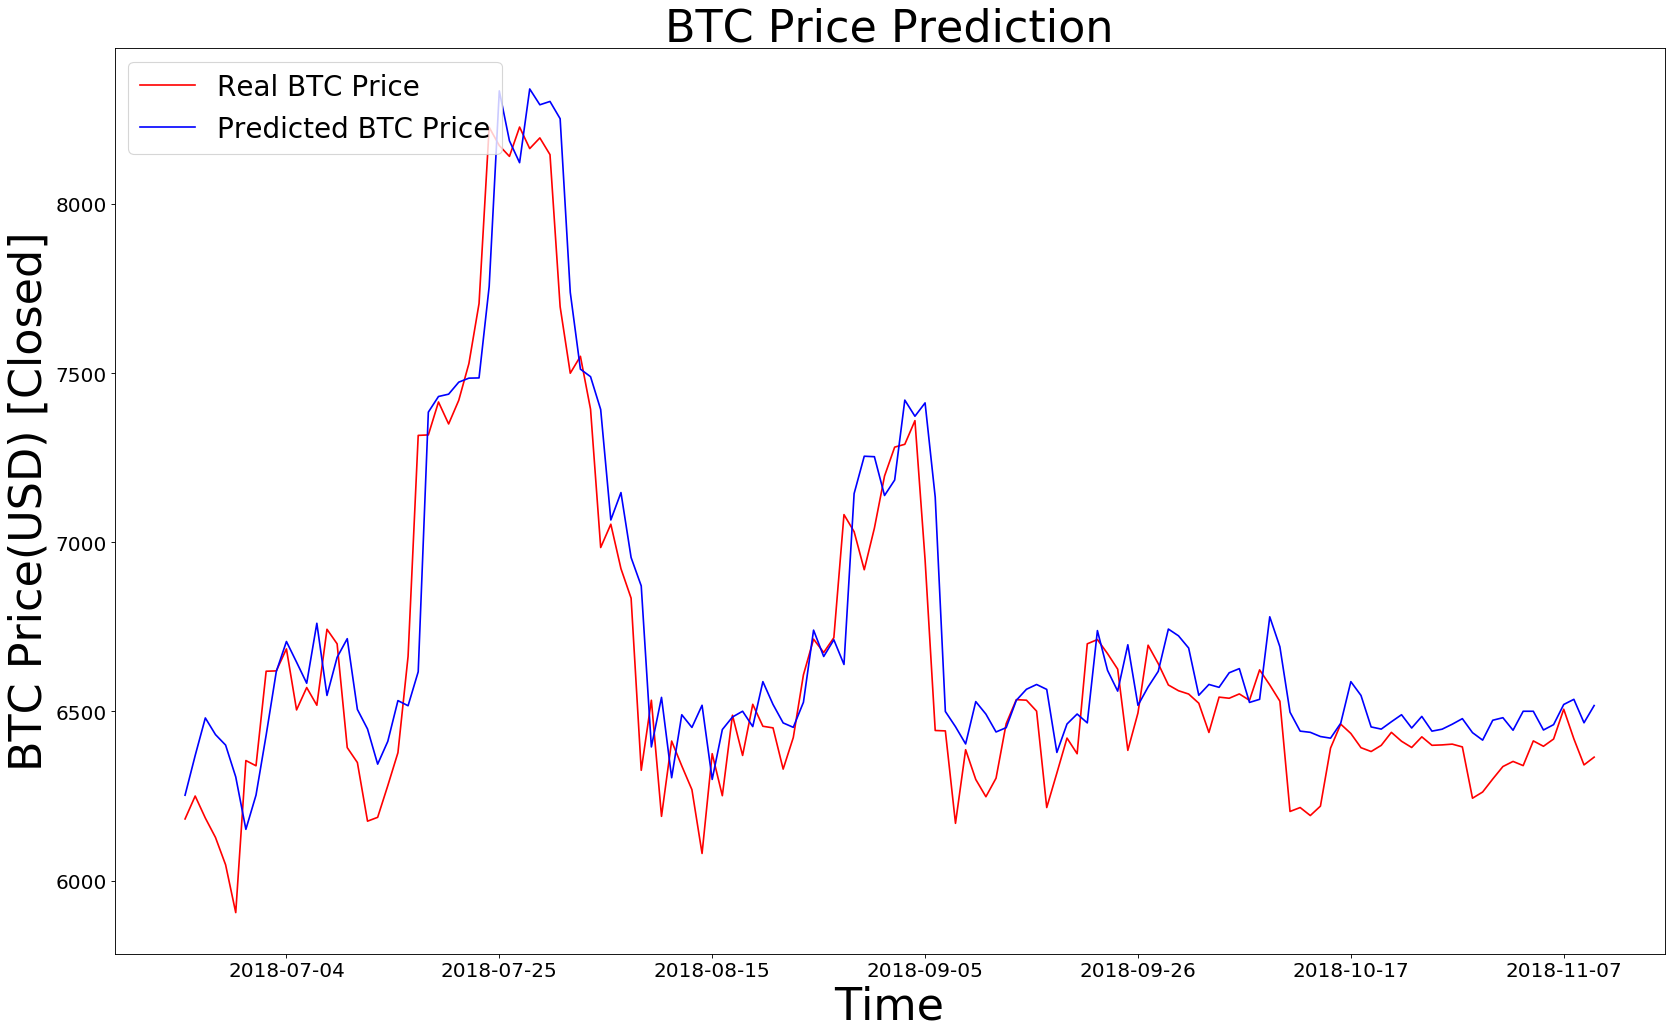

In [12]:
# Visualising the results
plt.figure(figsize=(25,15), dpi=80, facecolor='w', edgecolor='k')
ax = plt.gca()  
plt.plot(df_Result['NEXT_CLOSE'], color = 'red', label = 'Real BTC Price')
plt.plot(df_Result['Predicted'], color = 'blue', label = 'Predicted BTC Price')
plt.title('BTC Price Prediction', fontsize=40)
df_test = df_Result.reset_index()
x = df_test.index
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(18)
plt.xlabel('Time', fontsize=40)
plt.ylabel('BTC Price(USD) [Closed]', fontsize=40)
plt.legend(loc=2, prop={'size': 25})
plt.show()